# Path of destruction

Python script to import Hurricane data and a heuristical model for estimating home damage. We use data for Hurricane Irma from last year in our case study.

---

### Hurricane Irma 
September 8, 2017, 12 Zulu, Created @ ~9AM EST data forecasts

Source: https://www.nhc.noaa.gov/gis/archive_forecast_results.php?id=al11&year=2017&name=Hurricane%20IRMA  
File1: al112017_5day_037.zip (8:59 AM)    
File2: al112017_fcst_037.zip (9:00 AM)

In [1]:
# import packages
import pandas as pd 
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import geojson
from geojson import Point, Feature, FeatureCollection, dump
from shapely.geometry import shape, Point
from geopy.distance import geodesic
import tempfile
import fiona

import warnings
warnings.filterwarnings('ignore')

Import data from NOAA

In [2]:
HURRICANE_PATH = './al112017_5day_037/al112017-037_5day_lin.shp'
HURRICANE_ERROR_CONE = './al112017_5day_037/al112017-037_5day_pgn.shp'
HURRICANE_WIND_RADII = './al112017_fcst_037/al112017_2017090809_forecastradii.shp'

In [3]:
# path of hurricane
path = fiona.open(HURRICANE_PATH)
first_path = path.next()

path_features = []
# entire path of hurricane
path_features.append(Feature(geometry = first_path['geometry'], properties = {"hurricane": "Irma"}))

# add more features...
for i in range(0, 6):
    point = Point(first_path['geometry']['coordinates'][i])
    day = str(datetime.date(2008, 9, 10) + datetime.timedelta(i))
    # 5d predictions
    path_features.append(Feature(geometry = point, properties = {"day": day}))

In [4]:
# hurricane cone
cone = fiona.open(HURRICANE_ERROR_CONE)
first_cone = cone.next()
cone_features = []
cone_features.append(Feature(geometry = first_cone['geometry'], properties={"shape": "Prediction"})) 

In [33]:
# hurricane wind radii
radius = fiona.open(HURRICANE_WIND_RADII)
radius_features = []
for i in range(len(radius)):
    rad_num = radius[i]
    radius_features.append(Feature(geometry = rad_num['geometry'], properties = {"shape": "Prediction"})) 

## TODO: change by color

# process radii data - 3, 3, 3, 3, 2, 2 of radii
def apply_radius_list(radius_features):
    radius_df = {}
    for i in [0, 1, 2, 3]:
        radius_df[i] = [radius_features[j] for j in range(i, i + 3)]
    for i in [4, 5]:
        radius_df[i] = [radius_features[j] for j in range(i, i + 2)]
#         ['geometry']['coordinates'][0]
    return radius_df

radius_data = apply_radius_list(radius_features)

In [34]:
# dump data for Kepler
def generate_kepler_data():
    with open('./geojson/path.geojson', 'w') as f:
        dump(FeatureCollection(path_features), f)
    
    with open('./geojson/cone.geojson', 'w') as f:
        dump(FeatureCollection(cone_features), f)

    with open('./geojson/radii.geojson', 'w') as f:
        dump(FeatureCollection(radius_features), f)
        
generate_kepler_data()

Input data class and Point initialization for latitude longitude. Let's use Key West.

In [118]:
KeyWest = Point((-81.47, 24.33))
KeyWest = Point((-75.34144, 22.12434))
day = datetime.date(2018, 9, 12)
day_num = (day - datetime.date(2018, 9, 10)).days
day_num

2

In [119]:
# # in radius
# def find_in_radius(point = KeyWest, day_num = day_num):
#     found = []
#     radius_subset = radius_data[day_num]
#     for i in range(len(radius_subset)):
#         polygon = shape(radius_subset[i].geometry)
#         if(polygon.contains(point)):
#             point_num = 1 if (i == 0) else (-1 if (i == len(radius_subset) - 1) else 0)
#             point_name = 'fastest' if (i == 0) else ('slowest' if (i == len(radius_subset) - 1) else 'middle')
#             print('Found your location on day {} at {} wind radius'.format(day_num, point_name))
#             found.append(point_num) # days separate
#     return found

# # Missing days?
# find_in_radius(KeyWest, 2)

Found your location on day 2 at middle wind radius
Found your location on day 2 at slowest wind radius


[0, -1]

In [120]:
# # find distances to each circle
# def find_distance_circle(point = KeyWest, day_num = day_num):
#     point_coord = (point.coords.xy[0][0], point.coords.xy[1][0])
#     found = {}
#     radius_subset = radius_data[day_num]
#     for i in range(len(radius_subset)):
#         polygon = shape(radius_subset[i].geometry)
#         point_num = 1 if (i == 0) else (-1 if (i == len(radius_subset) - 1) else 0)

#         if(polygon.contains(point)):
#             found[point_num] = '' # don't include ones we're in
#         else:
#             found[point_num] = min([geodesic(point_coord, j).miles for j in polygon.exterior.coords]) # min distance
#     return found

# find_distance_circle(day_num = 2)

{1: 39.267639897961516, 0: '', -1: ''}

In [122]:
# # find distances to the eye
# def find_distance_eye(point = KeyWest, day_num = day_num):
#     point_coord = (point.coords.xy[0][0], point.coords.xy[1][0])
#     return geodesic(point_coord, tuple(path_features[day_num + 1]['geometry']['coordinates'])).miles

# find_distance_eye()

170.71001715803928

# model specification
- is it contained in the first radius
- if not, second radius?
- if not, 3rd radius?
- nearest radius it is not contained to's distance
- distance from the eye

In [200]:
day_num = 4

In [208]:
# at most 30% boost
radius_found = find_in_radius(KeyWest, day_num)
try:
    radius_weight = 0.25 + float(max(radius_found) * 0.1) # 0.35, 0.25, 0.15
except: # none were found - outside all of the radii
    radius_weight = 0
radius_weight

Found your location on day 4 at fastest wind radius
Found your location on day 4 at slowest wind radius


0.35

In [209]:
# # nearest radius
# # radius_found = [1, 0, -1]
# # at most 0.4
# dist = find_distance_circle(KeyWest, day_num)
# try:
#     if (max(radius_found) == 1):
#         radii_distance_weight = 0.4
#     else:
#         radii_distance_weight = (1 - dist[max(radius_found) + 1]/100) * (0.3 + 0.1 * max(radius_found))
# except: # none were found - outside all of the radii
#     radii_distance_weight = (1 - dist[max(radius_found) + 1]/100) * 0.1
# radii_distance_weight

0.4

In [214]:
# distance_weight = (1 - find_distance_eye(KeyWest, day_num)/1000) * 0.25
# distance_weight

0.1618612790555361

In [215]:
# # total 
# distance_weight + radii_distance_weight + radius_weight

0.9118612790555362

In [399]:
# class structure
class Insuricane():
    
    ### Initialization
    def __init__(self, Point, 
                 base_date = datetime.date(2017, 9, 8),
                 path_features = path_features, 
                 cone_features = cone_features, 
                 radius_data = radius_data):
        self.date = base_date # base date
        self.point = Point
        self.path_features = path_features
        self.cone_features = cone_features
        self.radius_data = radius_data
        
    def get_day_num(self, day):
        return min(5, (day - self.date).days)

    ### Calculating locations with our geojson data
    # which radii is it in for wind?
    def find_in_radius(self, day, suppressPrint = False):
        found = []
        radius_subset = self.radius_data[self.get_day_num(day)]
        for i in range(len(radius_subset)):
            polygon = shape(radius_subset[i].geometry)
            if(polygon.contains(point)):
                point_num = 1 if (i == 0) else (-1 if (i == len(radius_subset) - 1) else 0)
                point_name = 'fastest' if (i == 0) else ('slowest' if (i == len(radius_subset) - 1) else 'middle')
                
                if (suppressPrint == False):
                    print('Found your location on day {} at {} wind radius'.format(
                        self.get_day_num(day), point_name))
                found.append(point_num) # days separate
        return found
    
    # closest radii
    def find_distance_circle(self, day):
        point_coord = (self.point.coords.xy[0][0], self.point.coords.xy[1][0])
        found = {}
        radius_subset = self.radius_data[self.get_day_num(day)]
        for i in range(len(radius_subset)):
            polygon = shape(radius_subset[i].geometry)
            point_num = 1 if (i == 0) else (-1 if (i == len(radius_subset) - 1) else 0)

            if(polygon.contains(point)):
                found[point_num] = '' # don't include ones we're in
            else:
                found[point_num] = min([geodesic(point_coord, j).miles for j in polygon.exterior.coords])
        return found
    
    # distance to the eye on a given day
    def find_distance_eye(self, day):
        point_coord = (self.point.coords.xy[0][0], self.point.coords.xy[1][0])
        return geodesic(point_coord, 
                        tuple(path_features[self.get_day_num(day) + 1]['geometry']['coordinates'])).miles
    
    
    ### We want this to be able to change per day. We have the eye by day, we have radii by day.
    # radius weighting
    def __calc_radius_weight(self, day, **kwargs):
        radius_found = self.find_in_radius(day, **kwargs)
        try:
            radius_weight = 0.25 + float(max(radius_found) * 0.1) # 0.35, 0.25, 0.15
        except: # none were found - outside all of the radii
            radius_weight = 0
        return radius_weight

    # loop weighting
    def __calc_circle_weight(self, day, **kwargs):
        radius_found = self.find_in_radius(day, **kwargs)
        dist = self.find_distance_circle(day)
        try:
            if (max(radius_found) == 1):
                radii_distance_weight = 0.4
            else:
                radii_distance_weight = (1 - dist[max(radius_found) + 1]/100) * (0.3 + 0.1 * max(radius_found))
        except: # none were found - outside all of the radii
            radii_distance_weight = (1 - dist[max(radius_found) + 1]/100) * 0.1
        return radii_distance_weight

    ### Actual value 'heuristics' model
    # chance your house is destroyed
    def __calc_chance_hurricane(self, day, **kwargs):
        distance_weight = (1 - self.find_distance_eye(day)/1000) * 0.25
        return distance_weight + self.__calc_radius_weight(day, **kwargs) + self.__calc_circle_weight(day, **kwargs)
    
    # does this for each of the 5 days
    def calc_risk(self, **kwargs):
        hurrichance = {}
        for i in range(7):
            second_day = self.date + datetime.timedelta(i) # increment days
            hurrichance[second_day] = self.__calc_chance_hurricane(second_day, **kwargs)
        return pd.DataFrame(hurrichance, index = ['chance']).T
    
    # maximum chance of a hurricane
    def calc_max_hurricane(self):
        hurricane_a1 = self.calc_risk(suppressPrint = True) # never print for this
        hurricane_a1 = hurricane_a1[hurricane_a1.index != min(hurricane_a1.index)]
        hurricane_temp = hurricane_a1[hurricane_a1['chance'] == max(hurricane_a1['chance'])]
        return (hurricane_temp['chance'])

In [400]:
# initialize
BCG = Insuricane(KeyWest)

In [457]:
# chance of hurricane
BCG.calc_risk(suppressPrint = True)

,chance
2017-09-08,0.973202
2017-09-09,0.515246
2017-09-10,0.639520
2017-09-11,0.929477
2017-09-12,0.911861
2017-09-13,0.891382
2017-09-14,0.891382


In [401]:
# most dangerous day
BCG.calc_max_hurricane()

2017-09-11    0.929477
Name: chance, dtype: float64

In [455]:
# plot chance of getting owned by Irma
def plot_irmachance(city = 'Key West', point = KeyWest, alpha = 0.5):
    BCG = Insuricane(point)
    hurricane_ts = BCG.calc_risk(suppressPrint = True)
    
    hurricane_df = hurricane_ts[datetime.date(2017, 9, 9):]
    hurricane_df['ewm'] = hurricane_df.ewm(alpha).mean()
    hurricane_df = hurricane_df.applymap(lambda x: 100 * x)

    sns.set(font_scale = 1.1)
    sns.set_style('whitegrid')
    plt.figure(figsize = (8, 6))
    plt.plot(hurricane_df['chance'], marker = 'o', color = '#4285f4', alpha = 0.75, label = 'Chance of hurricane')
    plt.plot(hurricane_df['ewm'], linestyle = '--', color = '#DC143C', alpha = 0.5, label = 'Rolling likelihood')
    plt.xticks(rotation = -15)
    plt.xlabel('Date')
    plt.ylabel('Chance of hurricane')
    plt.title('Chance of {} homes destroyed'.format(city))
    
    plt.plot(BCG.calc_max_hurricane().index.values[0], 
             BCG.calc_max_hurricane().values[0] * 100, 
             color = '#4285f4', marker = 's', linestyle = 'none', label='Riskiest day')
    
    plt.legend()
    plt.show()

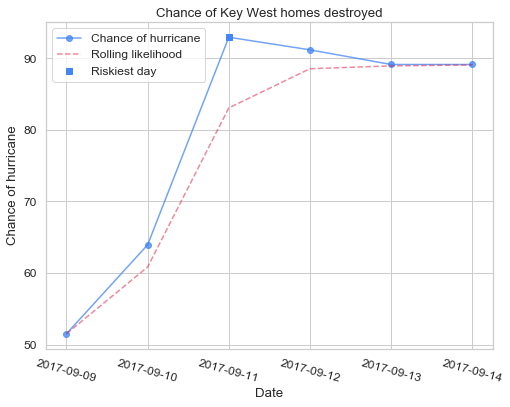

In [456]:
plot_irmachance()